<a href="https://colab.research.google.com/github/Diddi-RamaKrishna/Energy-Modelling-for-Renewable-Energy/blob/Renewable-Energy-modelling/Energy_Modelling_for_Wind%2C_Solar_and_Battery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
planted_capacity = 300
wind_capacity=300
solar_capacity = 200
battery_efficiency = 0.8
battery_capacity=100 #battery out of planted capacity

make the excel in this format and upload with year, month , day , time , wind profile and solar profile in the same order.



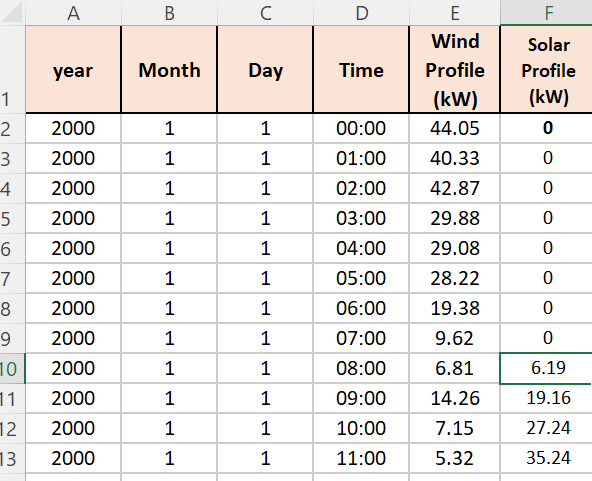

In [ ]:
import numpy as np
import pandas as pd
from google.colab import files

# Upload the Excel file
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]

# Read the Excel file into a DataFrame
df = pd.read_excel(filename)

# Extracting data from DataFrame columns
year = np.array(df.iloc[1:, 0])
month = np.array(df.iloc[1:, 1])
day = np.array(df.iloc[1:, 2])
time_values = np.array([time.strftime('%H:%M') for time in df.iloc[1:, 3]])
wind_profile = np.array(df.iloc[1:, 4], dtype=float)
solar_profile = np.array(df.iloc[1:, 5], dtype=float)

Saving Book100.xlsx to Book100.xlsx


In [ ]:
hourly_wind_generation = (wind_profile * wind_capacity) / 50
hourly_solar_generation = (solar_profile * solar_capacity) / 50
generation = np.add(hourly_wind_generation, hourly_solar_generation)

Here two types of demand profiles can be set

In [ ]:
import numpy as np
print("Enter the choice:")
print("1 for general demand")
print("2 for demand in specific times in morning and evening")
demand_values=[]
menu = int(input("Choice: "))
if menu==1:
  d=int(input("Enter the general demand : "))
  demand_values = np.ones(len(time_values)) * d
elif menu==2:
  x=["08:00","09:00"] # Enter the time periods in morning from 05:00 to 11:00
  y=["18:00","19:00"] # ENter the time periods in evening from 17:00 to 23:00
  a=x+y
  a = np.array(a)
  d=int(input("Enter the  demand : "))
  demand_values = np.where(np.isin(time_values, a), d, 0.0)
else:
  print("invalid")

Enter the choice:
1 for general demand
2 for demand in specific times in morning and evening
Choice: 2
Enter the  demand : 300


Enter the percentage in decimal that you want the battery to give w.r.t the deficit For example if deficit is 150 and you choose 0.7 , then 0.7*150=105 is taken from battery This is done to smoothen the curve

In [ ]:
battery_soc=battery_capacity/planted_capacity
s=0.75

In [ ]:
# @title energy_management
import numpy as np
import time
def energy_management(generation, demand_values, planted_capacity, battery_soc, battery_efficiency):
    start_time = time.time()
    # Pre-compute constants
    efficiency_loss_factor = (1 - battery_efficiency) * 5 / 4
    max_charge_capacity = planted_capacity * battery_soc
    # Calculate immediate generation and demand relationships
    generation_to_evacuate = np.minimum(generation, demand_values)
    deficit_values = np.maximum(0, demand_values - generation_to_evacuate)
    excess_energy_values = np.maximum(0, generation - demand_values)
    # Cumulative charging handling
    cumulative_charge_list = np.zeros_like(demand_values)
    cumulative_charging = 0
    for i in range(len(demand_values)):
        possible_charge = cumulative_charging + excess_energy_values[i]
        temp_value = min(possible_charge, max_charge_capacity)
        temp_value -= deficit_values[i] * (1 + efficiency_loss_factor)
        cumulative_charging = max(0, temp_value)
        cumulative_charge_list[i] = cumulative_charging
    # Hourly storage changes
    hourly_storage_results = np.where(
        (cumulative_charge_list == np.roll(cumulative_charge_list, 1)) &
        (cumulative_charge_list == max_charge_capacity),
        0,
        np.minimum(max_charge_capacity - np.roll(cumulative_charge_list, 1), excess_energy_values))
    # Withdrawal from storage
    withdrawal_from_storage_list = np.where(
        cumulative_charge_list > (np.roll(cumulative_charge_list, 1) + deficit_values),
        deficit_values*s,
        battery_efficiency * (np.roll(cumulative_charge_list, 1) - cumulative_charge_list + hourly_storage_results))
    # Calculating storage loss due to inefficiency
    storage_loss_list = withdrawal_from_storage_list * efficiency_loss_factor
    # Calculate excess energy after accounting for hourly storage
    excess_after_battery = np.maximum(0, excess_energy_values - hourly_storage_results)
    evacuated_post_charging_list = np.minimum(
        planted_capacity - (generation_to_evacuate + withdrawal_from_storage_list), excess_after_battery)
    evacuated_post_charging_list = np.where(
        (generation_to_evacuate + withdrawal_from_storage_list) < planted_capacity,
        evacuated_post_charging_list,
        0)
    # Final loss calculation
    final_loss_list = np.maximum(excess_after_battery - evacuated_post_charging_list, 0)
    DFR_without_MarketPurchase_list = np.where(
        demand_values > 0,
        (generation_to_evacuate + withdrawal_from_storage_list + evacuated_post_charging_list) / planted_capacity,
        0
    )
    loss_1_list = np.where(
        (generation_to_evacuate + withdrawal_from_storage_list + evacuated_post_charging_list + final_loss_list) <= planted_capacity,
        final_loss_list,
        planted_capacity - (generation_to_evacuate + withdrawal_from_storage_list + evacuated_post_charging_list)
    )
    loss_2_list = np.maximum(final_loss_list - loss_1_list, 0)
    '''print(f"Execution time: {time.time() - start_time:.2f} ms")
    print(f"Length of generation list: {len(generation)}")'''
    return {
        "Demand Values": demand_values,
        "Generation to Evacuate": generation_to_evacuate,
        "Deficit Values": deficit_values,
        "Excess Energy Values": excess_energy_values,
        "Cumulative Charge List": cumulative_charge_list,
        "Hourly Storage Results": hourly_storage_results,
        "Withdrawal from Storage List": withdrawal_from_storage_list,
        "Storage Loss List": storage_loss_list,
        "Excess After Battery": excess_after_battery,
        "Evacuated Post Charging List": evacuated_post_charging_list,
        "Final Loss List": final_loss_list,
        "DFR without Market Purchase": DFR_without_MarketPurchase_list,
        "Loss 1 List": loss_1_list,
        "Loss 2 List": loss_2_list }

In [ ]:
print(demand_values)

[  0.   0.   0.   0.   0.   0.   0. 300. 300.   0.   0.   0.   0.   0.
   0.   0.   0. 300. 300.   0.   0.   0.   0.]


In [ ]:
results = energy_management(generation, demand_values, planted_capacity, battery_soc, battery_efficiency)

In [ ]:
energy_supplied=results["Generation to Evacuate"]+results["Withdrawal from Storage List"]

In [ ]:
# @title Print the data to analyse
import pandas as pd

# Define your index variables
i = 0  # start index
j = 23 # end index

# Create the DataFrame using the index variables for slicing
data = {
    "year":year[i:j],
    "month":month[i:j],
    "time": time_values[i:j],
    "wind gen":hourly_wind_generation[i:j],
    "solar_gen":hourly_solar_generation[i:j],
    "generation": generation[i:j],
    "Demand Values": results["Demand Values"][i:j],
    "DFR without Market Purchase": results["DFR without Market Purchase"][i:j],
    "Energy Supplied":energy_supplied[i:j],
    "Generation to Evacuate": results["Generation to Evacuate"][i:j],
    "Deficit Values": results["Deficit Values"][i:j],
    "Excess Energy Values beyond Deficit": results["Excess Energy Values"][i:j],
    "Cumulative Charge List": results["Cumulative Charge List"][i:j],
    "Hourly Storage Results": results["Hourly Storage Results"][i:j],
    "Withdrawal from Storage List": results["Withdrawal from Storage List"][i:j],
    "Storage Loss List": results["Storage Loss List"][i:j],
    "Excess After Battery Charging": results["Excess After Battery"][i:j],
    "Evacuated Post Charging List": results["Evacuated Post Charging List"][i:j],
    "Final Loss List": results["Final Loss List"][i:j],
}
dfr=results["DFR without Market Purchase"]
dfr_new=[]
for i in range(len(dfr)):
  if dfr[i]!=0:
    dfr_new.append(dfr[i])
print("Overall DFR acheivable is : ",sum(dfr_new)/len(dfr_new))
print("")
# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)
# Set pandas options to display all columns and a wide display
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 1000)

# Print the DataFrame
print(df)


Overall DFR acheivable is :  0.4259833333333333

    year  month   time  wind gen  solar_gen  generation  Demand Values  DFR without Market Purchase  Energy Supplied  Generation to Evacuate  Deficit Values  Excess Energy Values beyond Deficit  Cumulative Charge List  Hourly Storage Results  Withdrawal from Storage List  Storage Loss List  Excess After Battery Charging  Evacuated Post Charging List  Final Loss List
0   2000      1  01:00    241.98       0.00      241.98            0.0                     0.000000             0.00                    0.00            0.00                               241.98                  100.00                    0.00                           0.0                0.0                         241.98                        241.98              0.0
1   2000      1  02:00    257.22       0.00      257.22            0.0                     0.000000             0.00                    0.00            0.00                               257.22                  10

In [ ]:
# Define your index variables
i = 0  # start index
j = 6 # end index

In [ ]:
# @title Save as Excel
import pandas as pd



# Create the DataFrame using the index variables for slicing
data = {
    "year":year[i:j],
    "month":month[i:j],
    "time": time_values[i:j],
    "wind gen":hourly_wind_generation[i:j],
    "solar_gen":hourly_solar_generation[i:j],
    "generation": generation[i:j],
    "Demand Values": results["Demand Values"][i:j],
    "Generation to Evacuate": results["Generation to Evacuate"][i:j],
    "Deficit Values": results["Deficit Values"][i:j],
    "Excess Energy Values": results["Excess Energy Values"][i:j],
    "Cumulative Charge List": results["Cumulative Charge List"][i:j],
    "Hourly Storage Results": results["Hourly Storage Results"][i:j],
    "Withdrawal from Storage List": results["Withdrawal from Storage List"][i:j],
    "Storage Loss List": results["Storage Loss List"][i:j],
    "Excess After Battery": results["Excess After Battery"][i:j],
    "Evacuated Post Charging List": results["Evacuated Post Charging List"][i:j],
    "Final Loss List": results["Final Loss List"][i:j],
    "DFR without Market Purchase": results["DFR without Market Purchase"][i:j],
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Set pandas options to display all columns and a wide display
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 1000)

# Print the DataFrame
print(df)

# Define the file name
file_name = "output.xlsx"

# Save the DataFrame to an Excel file
df.to_excel(file_name, index=False)

# Provide the file path for download
print("Excel file saved as:", file_name)
